<a href="https://colab.research.google.com/github/anniebritton/ISAMR-Research/blob/main/Wapusk_GreenUp_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Ideas

Pull wind speed and direction, sea ice (can play a big role in NDVI), albedo???

wget local weather station  - Wapusk

https://prairieclimatecentre.ca/about-us/ - modeling out predictions going forward

use variables to predict when the caribou would show up - ML

# **Colab Set Up**

In [ ]:
# installs and import libraries
!pip install earthengine-api
!pip install geemap
!pip install geopandas 
!pip install matplotlib
!pip install pyshp
!pip install pycrs


import ee
import geemap.foliumap as geemap
import shapefile
import pycrs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = (20,3)

In [ ]:
# initialise ee, copy and paste the authentication code
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

#**Import AOI**

In [48]:
# import and create a variable for the shapefile
AOI_path = "/content/drive/MyDrive/Personal/ISAMR/Shapefiles/Wapusk_Shapefile/wapusk_np_gcs.shp"

# convert the shapefile into an Earth Engine object
AOI = geemap.shp_to_ee(AOI_path)


In [ ]:
# Create a Map instance
map = geemap.Map()

# Add the AOI to the map
map.addLayer(AOI, {'color': 'red'}, name='AOI')

# Center the map on the AOI
map.centerObject(AOI)

# Display the map
map

#**MODIS Masking & NDVI Calculation**

In [161]:
# First, a function to mask out cloudy pixels
def mask_clouds(image):
    # Select the QA band
    QA = image.select('state_1km')
    # Make a mask to get bit 10, the internal cloud algorithm flag bit
    bit_mask = 1 << 10
    # Return an image masking out cloudy areas
    return image.updateMask(QA.bitwiseAnd(bit_mask).eq(0))


# Next, a function to mask out pixels with snow
def mask_snow(image):
    # Select the QA band
    QA = image.select('state_1km')
    # Make a mask to get bit 15, the internal snow mask bit
    bit_mask = 1 << 15
    # Return an image masking out snowy areas
    return image.updateMask(QA.bitwiseAnd(bit_mask).eq(0))


# Get MODIS surface reflectance image collection
mod09ga = ee.ImageCollection("MODIS/006/MOD09GA")

# Filter image collections by date and apply the mask_clouds and mask_snow functions
mod09ga_masked = mod09ga.filterDate('2000-02-27', '2021-12-31').map(mask_clouds)#.map(mask_snow)

In [162]:
# Next, a function to calculate and create a new NDVI band
def get_NDVI(imagecol):
    ndvi = imagecol.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename("NDVI")
    return imagecol.addBands(ndvi).select('NDVI').copyProperties(imagecol)

# Add NDVI as a band to the image
mod09ga_NDVI = mod09ga_masked.map(get_NDVI)

# **Data Acquisition**

In [163]:
# MODIS NDVI
NDVI_list = [mod09ga_NDVI, 'NDVI', AOI, 1000 ]

# MODIS Terra Snow Cover Daily Global 500m
NDSI_list = [ee.ImageCollection("MODIS/006/MOD10A1").filterDate('2000-02-27','2021-12-31'), 'NDSI_Snow_Cover', AOI, 500]

# MOD11A1.061 Terra Land Surface Temperature and Emissivity Daily Global 1km
DayLST_list = [ee.ImageCollection("MODIS/061/MOD11A1").filterDate('2000-02-27','2021-12-31'), 'LST_Day_1km', AOI, 1000]
NightLST_list = [ee.ImageCollection("MODIS/061/MOD11A1").filterDate('2000-02-27','2021-12-31'), 'LST_Night_1km', AOI, 1000]

# Daymet
Precip_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'prcp', AOI, 1000]
Srad_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'srad', AOI, 1000]
SWE_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'swe', AOI, 1000]
Tmax_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'tmax', AOI, 1000]
Tmin_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'tmin', AOI, 1000]
VaporPres_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'vp', AOI, 1000]

In [164]:
def spatialtimeseries(datalist):
  
    data = datalist[0]
    band = datalist[1]
    geometry = datalist[2]
    scale = datalist[3]

    # reduce the image collection to the area of study and to the correct bands
    def aoi_mean(img):
        mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry, scale=scale).get(band)
        return img.set('date', img.date().format()).set('mean', mean)

    # Map this function to every image in our collection to get a new 
    # ImageCollection, but now each image has the mean value for the region of interest and the date. 
    aoi_reduced_imgs = data.map(aoi_mean)

    # Reduce the images to a list of lists:
    # for each image, we have a 2-element list that contains that images date and mean value (for our point of interest)
    # each of these lists are themselves elements in our outer list, which is what we’ll convert to a dataframe
    nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

    # This nested list can be turned into a dataframe using the .DataFrame constructor.
    # Call the callback method "getInfo" to retrieve the data
    df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

    # Set the date column to be the index.
    df['date'] = pd.to_datetime(df['date']).dt.date
    df = df.set_index('date')

    return(df)

In [165]:
# MODIS NDVI
NDVI_df = spatialtimeseries(NDVI_list)

In [166]:
# MODIS Terra Snow Cover Daily Global 500m
NDSI_df = spatialtimeseries(NDSI_list)

In [167]:
# MOD11A1.061 Terra Land Surface Temperature and Emissivity Daily Global 1km
DayLST_df = spatialtimeseries(DayLST_list) 
NightLST_df = spatialtimeseries(NightLST_list)

# Adjust for MODIS temperature scale and convert to C
DayLST_df = DayLST_df * 0.02 - 273.15
NightLST_df= NightLST_df * 0.02 - 273.15

In [168]:
# Daymet 1
Precip_df = spatialtimeseries(Precip_list)
Srad_df = spatialtimeseries(Srad_list)
SWE_df = spatialtimeseries(SWE_list)

In [169]:
# Daymet 2
Tmax_df = spatialtimeseries(Tmax_list)
Tmin_df = spatialtimeseries(Tmin_list)
VaporPres_df = spatialtimeseries(VaporPres_list)

In [182]:
# Create a list of the dataframe names
df_list = [NDVI_df, NDSI_df, DayLST_df, NightLST_df, Precip_df, Srad_df, SWE_df, Tmax_df, Tmin_df, VaporPres_df]

# Create a list of the variables names
var_names = ['NDVI', 'NDSI', "DayLST", "NightLST", "Precip", "SolarRad", "SWE", "Tmax", "Tmin", "VaporPressure"]

# Create an empty dataframe to fill
df_whole = pd.DataFrame()

# Set the index to match the index of the data 
# using tmin because it runs for the full daily series of data
df_whole.index = Tmax_df.index

# For loop that adds each column to the new df and renames it
for i, df in enumerate(df_list):
  df_whole[var_names[i]] = df['mean']

# reset the index to avoid annoying datetime issues
df_whole = df_whole.reset_index()
df_whole['date'] = pd.to_datetime(df_whole['date'], utc=True).dt.strftime('%Y-%m-%d')
df_whole = df_whole.set_index('date')
# df_whole.index = pd.to_datetime(df_whole.index)

# interpolate missing values
df_whole = df_whole.interpolate(method='linear')
df_whole

,NDVI,NDSI,DayLST,NightLST,Precip,SolarRad,SWE,Tmax,Tmin,VaporPressure
date,,,,,,,,,,
2000-02-27,-0.048876,76.516149,-11.970387,-18.151989,0.000000,153.667617,64.911445,-10.784094,-17.797520,150.873357
2000-02-28,-0.072761,82.846451,-6.160794,-17.650815,0.000000,210.378199,64.911445,-4.231809,-15.375307,183.953540
2000-02-29,-0.061857,71.230067,-10.969949,-18.053482,0.065479,141.917274,64.976944,-7.790133,-13.929580,209.196236
2000-03-01,-0.066876,73.296511,-11.131869,-12.265676,0.000008,235.579445,64.976950,-3.164199,-16.269884,168.657866
2000-03-02,-0.041016,69.512972,-2.359538,-14.285173,0.000000,179.845880,64.976950,-0.943830,-8.956282,308.644252
...,...,...,...,...,...,...,...,...,...,...
2021-12-26,-0.025733,64.503176,-30.551036,-27.056629,0.000000,44.804853,29.105918,-20.152488,-31.748698,42.644328
2021-12-27,-0.051404,60.832824,-31.194905,-33.474352,0.000000,41.419877,29.105918,-23.135591,-32.775185,38.570735
2021-12-28,-0.045369,62.791685,-31.911936,-32.454444,0.000000,32.320825,29.105918,-21.226347,-27.668271,62.752782


# **Moving Average Analysis**

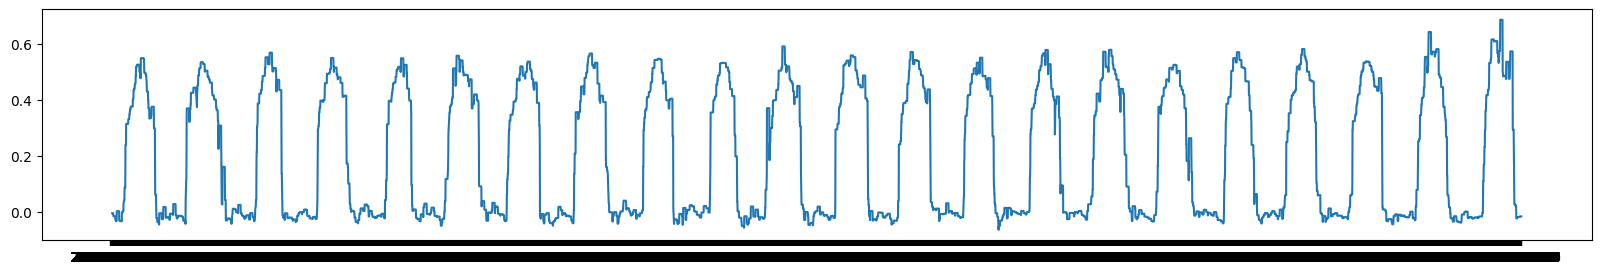

In [184]:
rolling = df_whole[["NDVI"]].rolling(window=14).max()
plt.plot(rolling)

In [117]:
# Find the date of max NDVI for each year in the DF

#**Time Series Decomposition**

In [ ]:
!pip install statsmodels
import statsmodels.api as sm

In [ ]:
# Load time series data
# Assuming you have a time series data stored in a variable called 'time_series_data'
# # Set the DataFrame index to be a DateTimeIndex
# df = df_whole.reset_index()
# df = df.set_index(pd.to_datetime(df['date'])) 

# # # Specify the frequency of the data (e.g., 'D' for daily, 'M' for monthly, 'Y' for yearly, etc.)
# # df.index.freq = 'D'

# Perform time series decomposition
decomposition = sm.tsa.seasonal_decompose(df_whole[["NDVI"]])

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(time_series_data, label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#**Calculate Anomalies**

In [ ]:
# Function that will calculate the daily mean for each variable and then 
# subsequently calculate the anomaly for each variable/day
def calculate_anomaly(df, value_col):
    
    # Group the data by day of the year and calculate the average for each day of the year
    df_daily_grouping = df.groupby(df.index.dayofyear).mean()

    # Create a dictionary mapping day of year to average value
    day_of_year_to_mean = df_daily_grouping[value_col].to_dict()

    # Map the day of year to the average value for that day of year
    df['day_of_year'] = df.index.dayofyear
    df[f'day_of_year_{value_col}_mean'] = df['day_of_year'].map(day_of_year_to_mean)

    # Calculate the daily anomaly as the difference between the original value and the average value for that day of year
    df[f'{value_col}_anomaly'] = df[value_col] - df[f'day_of_year_{value_col}_mean']

# NOTE - I am doing this before resampling we want to look at each day of the year here.
# If we did this after resampling, because of the way the pentads work, we would have
# less data to compare year to year.

# Apply the function to each column of the dataframe
for col in df_ndvi.columns:
    if col != 'date':
        calculate_anomaly(df_ndvi, col)

In [ ]:
# Reduce the dataframe so that it only contains the anomaly data
df_anom = df_ndvi[df_ndvi.columns[df_ndvi.columns.str.endswith('_anomaly')]]

# Move the NDVI column to the first position in the dataframe
df_anom.insert(0, 'NDVI_anomaly', df_anom.pop('NDVI_anomaly'))